# Imports

In [33]:
## LOAD LIBRARIES
import pandas as pd
import numpy as np

# Import all we need from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

#Import optuna
import optuna

# Import visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [34]:
df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Machine_Learning/Supervised_Learning/Data/Clean_Data_Titanic.csv')
print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  adult_male  \
0         0       3    male  22.0      1      0   7.2500        S        True   
1         1       1  female  38.0      1      0  71.2833        C       False   
2         1       3  female  26.0      0      0   7.9250        S       False   
3         1       1  female  35.0      1      0  53.1000        S       False   
4         0       3    male  35.0      0      0   8.0500        S        True   

   alone  
0  False  
1  False  
2   True  
3  False  
4   True  


# Label Encoding

In [35]:
## CONVERT CATEGORICAL LABELS TO NUMERIC LABELS

le = LabelEncoder()
df['survived'] = le.fit_transform(df['survived'])

# OneHot Encoding of Categorical Variables

In [36]:
label_col = 'survived'

labels = df[label_col]
df.drop([label_col], inplace=True, axis=1)
df = pd.get_dummies(df, dtype='int', columns = ['pclass', 'sex', 'embarked', 'alone', 'adult_male'])
df[label_col] = labels

# Normalize Data

In [37]:
label_col = 'survived'
labels = df[label_col]

scaler = MinMaxScaler(feature_range=(0, 1))
cols = df.loc[:, df.columns != label_col].columns
df = scaler.fit_transform(df.iloc[:,:-1])
df = pd.DataFrame(df, columns=cols)
df[label_col] = labels

# Create Train and Test Sets

### For No Cross Validation

In [38]:
# X will contain all variables except the labels (the labels are the first column 'survived')
X = df.iloc[:,:-1]
# y will contain the labels (the labels are the first column 'survived')
y = df['survived']
               
# split the data vectors randomly into 80% train and 20% test
# X_train contains the quantitative variables for the training set
# X_test contains the quantitative variables for the testing set
# y_train contains the labels for training set
# y_test contains the lables for the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Fit Initial Model

In [39]:
# documentation for parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LOGR_Classifier = linear_model.LogisticRegression()
LOGR_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = LOGR_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[96 14]
 [17 52]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



# Tune Model - W/O Cross Validation

In [40]:
def objective(trial, X_train, y_train, X_test, y_test):

    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1),
        "tol": trial.suggest_uniform("tol", 1e-6, 13-3),
    }

    # Fit the model
    optuna_model = linear_model.LogisticRegression(**param)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    score_metric = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    return score_metric

In [41]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 17:49:57,321] A new study created in memory with name: no-name-be61bb21-4a8a-49c9-adc6-48c7cfa0727e


In [42]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

C:\Users\casey\AppData\Local\Temp\ipykernel_9192\819053889.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-2, 1),
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\819053889.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "tol": trial.suggest_uniform("tol", 1e-6, 13-3),
[I 2024-03-23 17:49:57,353] Trial 0 finished with value: 0.3806228373702422 and parameters: {'C': 0.03792737039244864, 'tol': 0.6256192234711021}. Best is trial 0 with value: 0.3806228373702422.
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\819053889.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

C:\Users\casey\AppData\Local\Temp\ipykernel_9192\819053889.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-2, 1),
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\819053889.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "tol": trial.suggest_uniform("tol", 1e-6, 13-3),
[I 2024-03-23 17:49:58,587] Trial 19 finished with value: 0.3806228373702422 and parameters: {'C': 0.05791722996074038, 'tol': 6.263952526258914}. Best is trial 10 with value: 0.8340600858369098.
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\819053889.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

Best Trial:  FrozenTrial(number=10, state=1, values=[0.8340600858369098], datetime_start=datetime.datetime(2024, 3, 23, 17, 49, 57, 517992), datetime_complete=datetime.datetime(2024, 3, 23, 17, 49, 57, 575076), params={'C': 0.03837860675440512, 'tol': 0.056240687350323726}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'tol': FloatDistribution(high=10.0, log=False, low=1e-06, step=None)}, trial_id=10, value=None)
Best Params:  {'C': 0.03837860675440512, 'tol': 0.056240687350323726}


### Cross Validate Tuned Model

In [43]:
cv_model = linear_model.LogisticRegression(**best_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.7969574  0.68953539 0.78318064 0.73513276 0.71059783]
Average CV Score:  0.7430808049579798
Number of CV Scores used in Average:  5


# Tune Model With Cross Validation

In [44]:
def objective(trial, X_train, y_train):

    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1),
        "tol": trial.suggest_uniform("tol", 1e-6, 13-3),
    }

    # Fit the model with cv
    cv_model = linear_model.LogisticRegression(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

    # Evaluate predictions
    return scores.mean()

In [45]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 17:50:03,858] A new study created in memory with name: no-name-cc79d272-d4a0-4dc3-a620-32b84a9f6385


In [46]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

C:\Users\casey\AppData\Local\Temp\ipykernel_9192\2114803648.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-2, 1),
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\2114803648.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "tol": trial.suggest_uniform("tol", 1e-6, 13-3),
[I 2024-03-23 17:50:04,031] Trial 0 finished with value: 0.3814069633929137 and parameters: {'C': 0.028930154697177194, 'tol': 9.260393929522415}. Best is trial 0 with value: 0.3814069633929137.
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\2114803648.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[I 2024-03-23 17:50:04,285] Trial 3 finished with value: 0.3814069633929137 and parameters: {'C': 0.012644759808018623, 'tol': 8.70622636232028}. Best is trial 0 with value: 0.3814069633929137.
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\2114803648.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-2, 1),
C:\Users\casey\AppData\Local\Temp\ipykernel_9192\2114803648.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "tol": trial.suggest_uniform("tol", 1e-6, 13-3),
[I 2024-03-23 17:50:04,375] Trial 4 finished with value: 0.3814069633929137 and parameters: {'C': 0.1142854391471082, 'tol': 3.422992774295823}. Best is trial 0 with value: 0.381406963

Best Trial:  FrozenTrial(number=88, state=1, values=[0.7798301354208345], datetime_start=datetime.datetime(2024, 3, 23, 17, 50, 10, 4718), datetime_complete=datetime.datetime(2024, 3, 23, 17, 50, 10, 76714), params={'C': 0.07311419149143074, 'tol': 1.558696735116244e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'tol': FloatDistribution(high=10.0, log=False, low=1e-06, step=None)}, trial_id=88, value=None)
Best Params:  {'C': 0.07311419149143074, 'tol': 1.558696735116244e-05}


### Validate CV Model with Test Set

In [47]:
LOGR_Classifier = linear_model.LogisticRegression(**best_params)
LOGR_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = LOGR_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[104   6]
 [ 21  48]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       110
           1       0.89      0.70      0.78        69

    accuracy                           0.85       179
   macro avg       0.86      0.82      0.83       179
weighted avg       0.85      0.85      0.84       179



# Confusion Matrix

[[104   6]
 [ 21  48]]


[Text(0, 0.5, '0:'), Text(0, 1.5, '1:')]

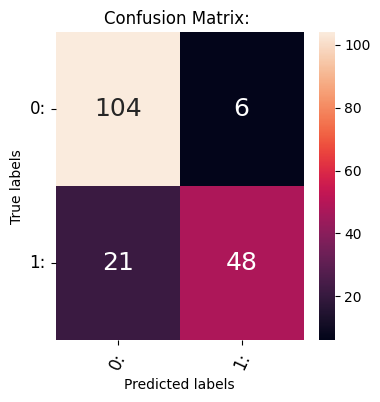

In [48]:
cm=confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)

# ---------------------------------------------------------------------------------------------------------------------------- #
## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: ')
ax.xaxis.set_ticklabels(["0:","1:"],rotation=65, fontsize = 12)

ax.yaxis.set_ticklabels(["0:","1:"],rotation=0, fontsize = 12)

# Feature Importance

C:\Users\casey\AppData\Local\Temp\ipykernel_9192\2634735176.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=idx,x=values,palette=clrs).set(title='Important Features to Predict the Total Result')


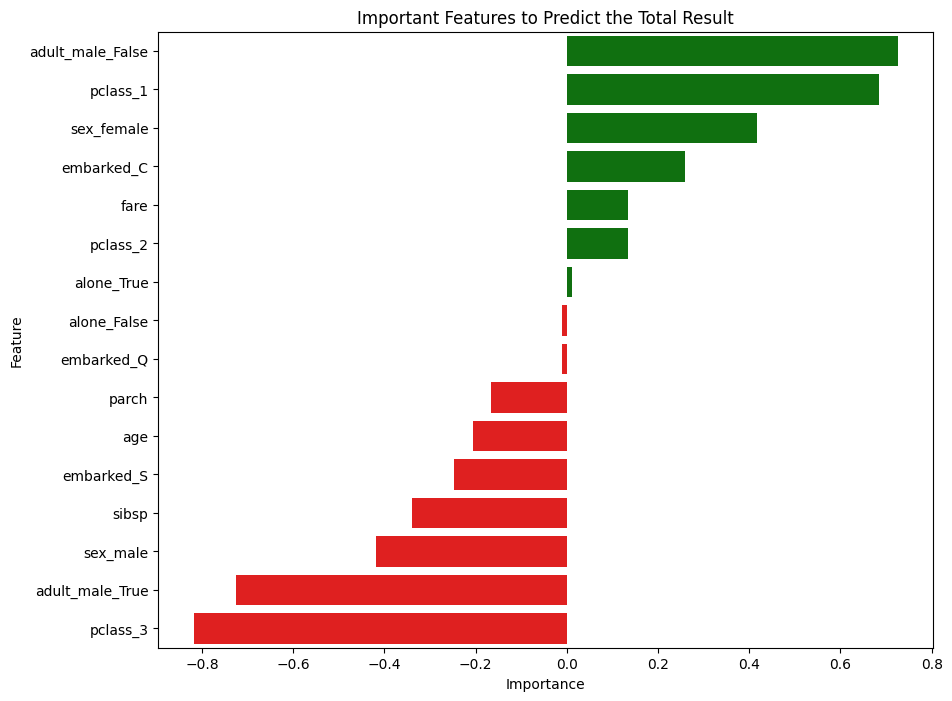

In [49]:
LOGR_Classifier.coef_[0]

feat_dict= {}
for col, val in sorted(zip(X_train.columns, LOGR_Classifier.coef_[0]),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
  
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

## PLOT FEATURE IMPORTANCE
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x > 0) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important Features to Predict the Total Result')
plt.show()